In [1]:
# basic
import numpy as np
import pandas as pd
import pprint

# plot
#import seaborn as sns
import matplotlib.pyplot as plt

# preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder

# model
import lightgbm as lgb

# optimization
from functools import partial
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import mean_squared_error as MSE, make_scorer

# importance
import eli5
from eli5.sklearn import PermutationImportance

# other
import pickle
import time
import datetime
#import sys
#import gc

D:\app-data\miniconda-dir\envs\ml\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
D:\app-data\miniconda-dir\envs\ml\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [10]:
train = pd.read_csv('../data/input/train.csv')
test = pd.read_csv('../data/input/test.csv')
sample_sub = pd.read_csv('../data/input/sample_submit.csv', header=None, names=['id', 'mpg'])

train_test = pd.concat([train, test], ignore_index=True, sort=False)

# Preprocessing

## car name, car brand

In [11]:
train_test['car name'] = train_test['car name'].str.replace('vw', 'volkswagen')
train_test['car name'] = train_test['car name'].str.replace('vokswagen', 'volkswagen')
train_test['car name'] = train_test['car name'].str.replace('toyouta', 'toyota')
train_test['car name'] = train_test['car name'].str.replace('chevy', 'chevrolet')
train_test['car name'] = train_test['car name'].str.replace('datsun 200-sx', 'datsun 200sx')

train_test['car name'] = train_test['car name'].str.replace('datsun 210 mpg', 'datsun 210')
train_test['car name'] = train_test['car name'].str.replace('ford gran torino (sw)', 'ford gran torino')

In [12]:
train_test['car_brand'] = train_test['car name'].apply(lambda x: x.strip().split(' ')[0])

## horse power

In [13]:
train_test['horsepower'].replace('?', np.nan, inplace=True)
train_test['horsepower'] = train_test['horsepower'].astype(float)

In [14]:
# car name毎のhorse powerの平均値を計算(nanは計算外)
name_hp_mean = train_test.groupby('car name').horsepower.mean()
df_hp_isnull = train_test[train_test['horsepower'].isnull()]

# nan位置のtrainデータのhorse powerを置換する
for i in df_hp_isnull.index:
    train_test.loc[i, 'horsepower'] = name_hp_mean[df_hp_isnull.loc[i, 'car name']]
    
del df_hp_isnull, name_hp_mean

# Encoding

# cat_cols = ['car name', 'car_brand']
for cols in cat_cols:
    train_test[cols] = LabelEncoder().fit_transform(train_test[cols])

del cat_cols

# Drop unimportant features

In [15]:
train_test.drop(['car name', 'car_brand'], axis=1, inplace=True)
display(train_test)

,id,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,0,23.059782,6,140,110.0,2815,17.977429,80,1
1,3,17.674521,8,350,150.0,4456,13.514535,72,1
2,4,17.136353,8,302,140.0,2774,13.209912,79,1
3,7,22.664666,6,400,85.0,2190,15.196381,71,1
4,9,17.872018,8,429,220.0,2245,9.621400,70,1
...,...,...,...,...,...,...,...,...,...
995,992,NaN,4,225,105.0,3870,15.376311,76,1
996,993,NaN,4,140,112.0,2720,13.616843,82,1
997,996,NaN,8,318,110.0,2774,13.272636,75,1
998,998,NaN,4,90,75.0,2807,17.792560,77,1


# Create Model

In [16]:
test_treated = train_test[train_test['mpg'].isnull()].copy()
train_treated = train_test.dropna(subset=['mpg'], axis=0).copy()

train_X = train_treated.drop(['id', 'mpg'], axis=1)
train_y = train_treated['mpg']

#del train_test

In [17]:
def RMSE(y_true, y_pred):
    return(np.sqrt(MSE(y_true, y_pred)))

def objective(X, y, args):
    args['max_depth'] = int(args['max_depth'])
    args['num_leaves'] = int(args['num_leaves'])
    args['min_data_in_leaf'] = int(args['min_data_in_leaf'])
    
    model = lgb.LGBMRegressor(**args)
    
    kf = KFold(n_splits=4, shuffle=True, random_state=1)
    
    score_func = {
        'score':make_scorer(RMSE)
    }
    
    scores = cross_validate(model, X=X, y=y, cv=kf, return_estimator=True, scoring=score_func)
    
    #history.append((model, scores))
    
    return {
        'loss':scores['test_score'].mean(),
        'status':STATUS_OK,
        'params':args
    }

In [22]:
# 変数候補すべてを最適化
param_space = {
    'alpha' : hp.loguniform(label='alpha', low=np.log(1e-8), high=np.log(1.0)),
    'bagging_fraction': hp.quniform(label='bagging_fraction', low=0.6, high=0.95, q=0.05),
    'feature_fraction': hp.quniform(label='feature_fraction', low=0.6, high=0.95, q=0.05),
    'gamma': hp.quniform(label='gamma', low=0.1, high=0.3, q=0.1),
    'lambda' : hp.loguniform(label='lambda', low=np.log(1e-6), high=np.log(10.0)),
    'max_depth': hp.quniform(label='max_depth', low=3, high=9, q=1),
    'min_child_weight': hp.quniform(label='min_child_weight', low=1, high=5, q=1),
    'min_data_in_leaf': hp.quniform(label='min_data_in_leaf', low=5, high=20, q=2),
    'num_leaves': hp.quniform(label='num_leaves', low=10, high=60, q=10)
}

#history = []

f = partial(objective, train_X, train_y)
trials=Trials()

best = fmin(
    fn=f,
    space=param_space, 
    algo=tpe.suggest, 
    trials=trials,
    max_evals=1000
)

100%|█████████████████████████████████████████████| 1000/1000 [02:36<00:00,  6.38trial/s, best loss: 2.937446342084411]


In [23]:
# trialsからスコアとパラメータを取り出し
result = [(i['loss'], i['params']) for i in sorted(trials.results, key=lambda x: x['loss'])]
# スコアとパラメータそれぞれをリスト、辞書に
losses = [i[0] for i in result]
opt_params = [i[1] for i in result]
# スコアとパラメータをDataFrame化
opt_params_df = pd.concat([pd.Series(losses, name='loss'), pd.DataFrame(opt_params)], axis=1)
display(opt_params_df)

,loss,alpha,bagging_fraction,feature_fraction,gamma,lambda,max_depth,min_child_weight,min_data_in_leaf,num_leaves
0,2.937446,0.263046,0.90,0.60,0.2,0.169385,5,3,6,20
1,2.940469,0.000378,0.75,0.75,0.2,0.230294,5,3,6,10
2,2.940538,0.007746,0.80,0.75,0.1,0.228801,5,3,6,10
3,2.945271,0.178847,0.85,0.60,0.2,0.209226,5,3,6,40
4,2.949978,0.000444,0.75,0.75,0.2,0.235214,5,3,6,10
...,...,...,...,...,...,...,...,...,...,...
995,3.158419,0.000016,0.65,0.95,0.2,0.000759,5,3,6,50
996,3.162940,0.000038,0.75,0.95,0.2,0.199057,5,3,6,10
997,3.165871,0.000049,0.80,0.95,0.2,9.237272,5,3,6,10
998,3.167983,0.306936,0.95,0.95,0.2,0.546336,5,3,6,20


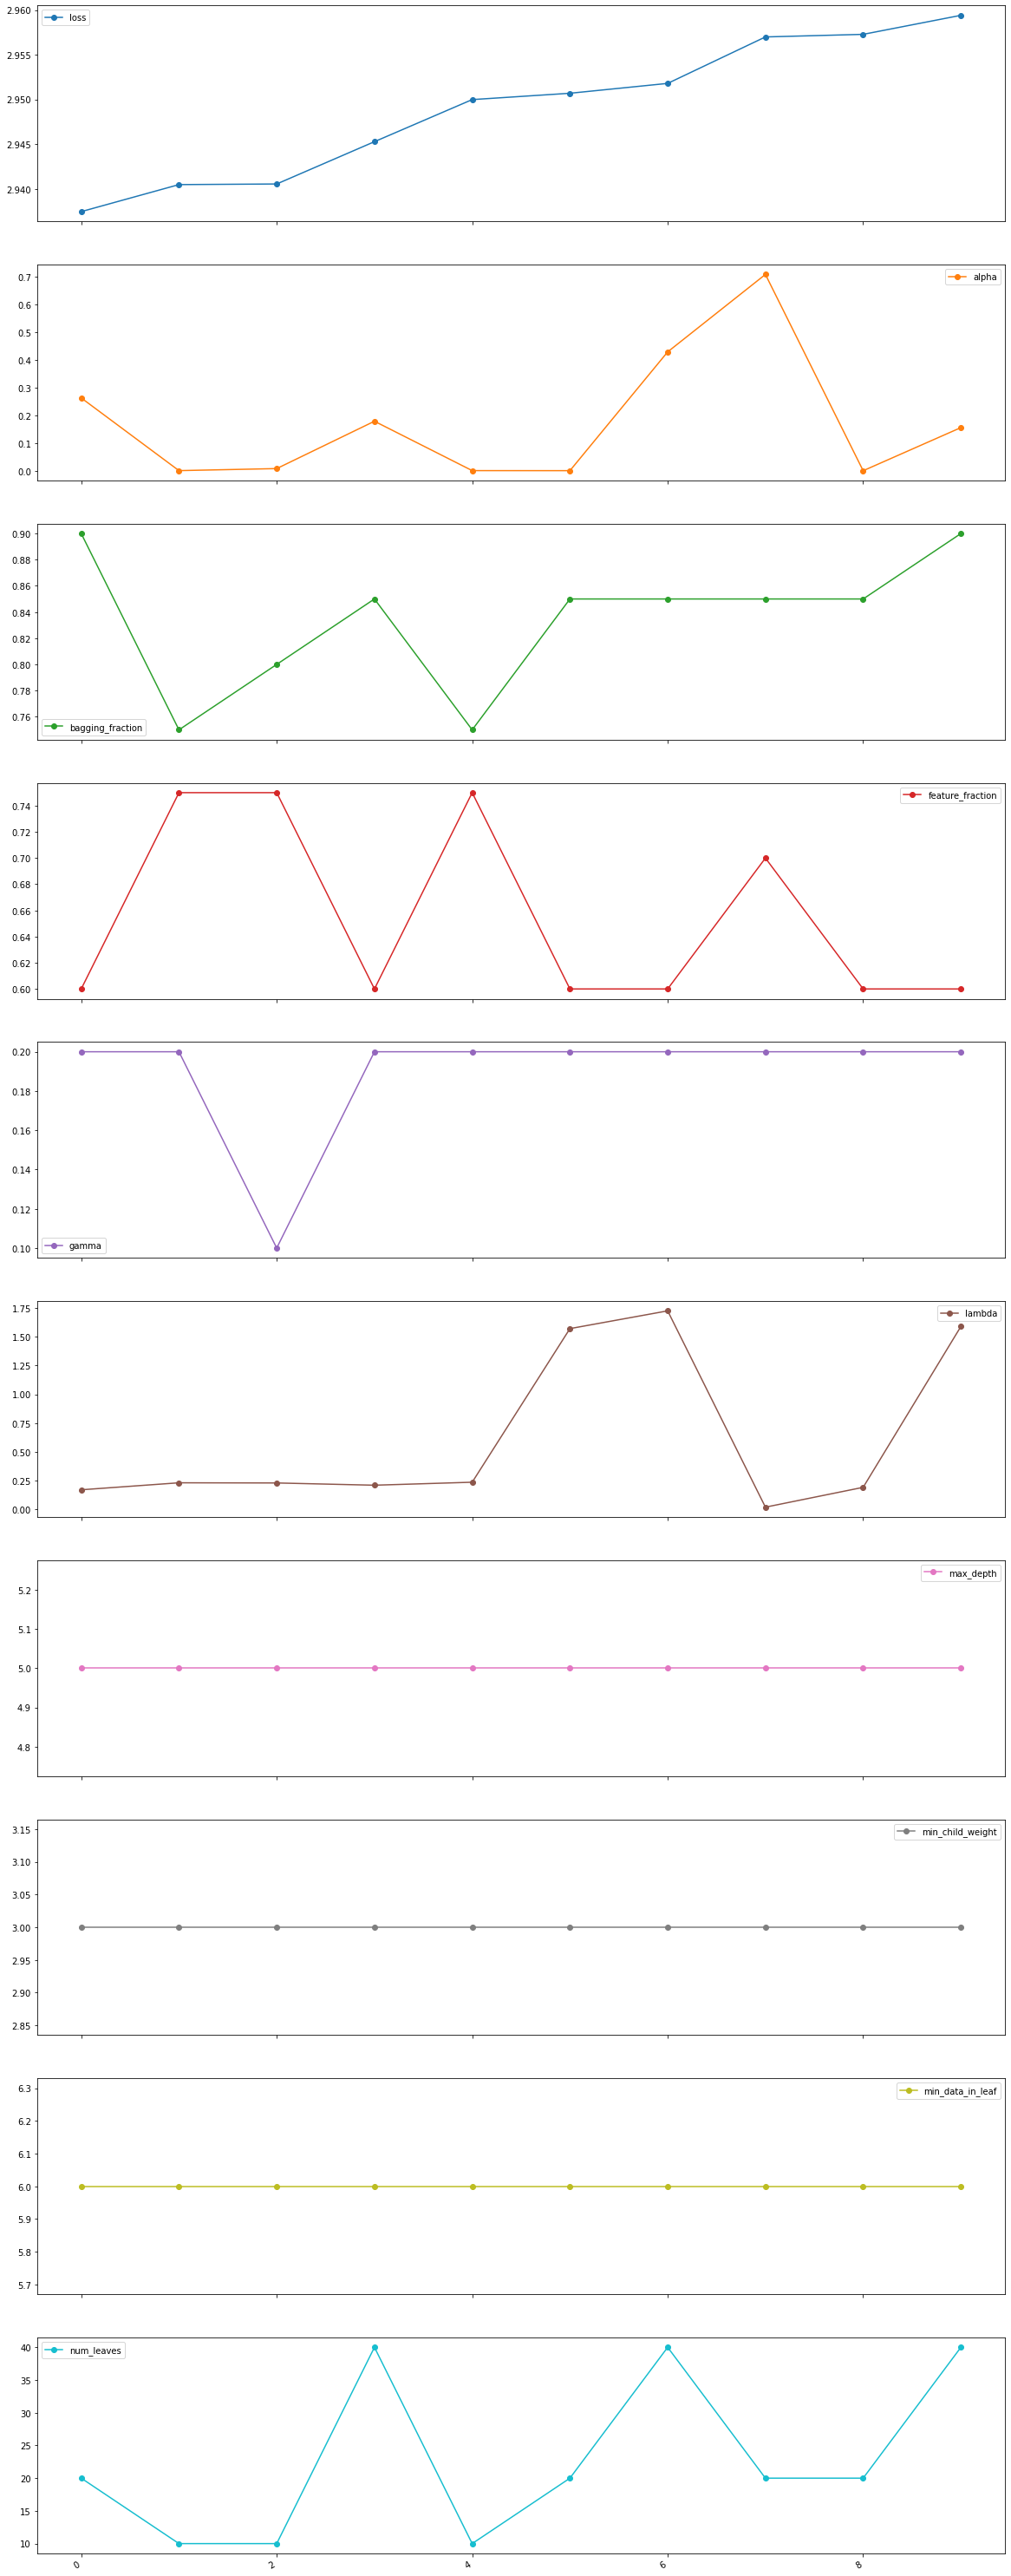

In [24]:
opt_params_df.iloc[:10, :].plot.line(figsize=(20, 60), layout=(10, 1), marker='o', subplots=True, legend=True)
plt.show()

In [25]:
# ベストスコアとそのときのパラメータを記録
best_loss = losses[0]
best_params = opt_params[0]

In [26]:
print("best_loss: ")
pprint.pprint(best_loss)
print("\nbest_params: ")
pprint.pprint(best_params)

best_loss: 
2.937446342084411

best_params: 
{'alpha': 0.2630459930880449,
 'bagging_fraction': 0.9,
 'feature_fraction': 0.6000000000000001,
 'gamma': 0.2,
 'lambda': 0.16938525736701832,
 'max_depth': 5,
 'min_child_weight': 3,
 'min_data_in_leaf': 6,
 'num_leaves': 20}


# Create Submission

In [27]:
dt = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
submission = pd.DataFrame({'id':sample_sub.id})
importance_list = []

best_model = lgb.LGBMRegressor(**best_params)
best_model.fit(train_X, train_y)
submission = pd.concat(
    [submission, pd.Series(best_model.predict(test_treated.drop(['id', 'mpg'], axis=1)), name='pred')],
    axis=1
)

display(submission)

,id,pred
0,1,36.187448
1,2,29.198405
2,5,27.338606
3,6,30.530922
4,8,25.090399
...,...,...
495,992,27.615641
496,993,29.739287
497,996,17.638240
498,998,27.338606


### Save files

In [28]:
# features
train_treated.to_pickle('../features/feature_train_' + dt + '_car_name_drop.pkl')
test_treated.to_pickle('../features/feature_test_' + dt + '_car_name_drop.pkl')

# submission
submission[['id', 'pred']].to_csv('../data/output/sub_' + dt + '_lightgbm.csv', header=False, index=False)
# model
pickle.dump(best_model, open('../models/model_' + dt + '_lightgbm.pickle', 'wb'))
# best parameter
pickle.dump(best_params, open('../logs/params_' + dt + '.pickle', 'wb'))
# best train score
pickle.dump(best_loss, open('../logs/logs_test_score' + dt + '.pickle', 'wb'))

# Check Importance

## lgb importance method

In [29]:
importance_df = pd.DataFrame(
    best_model.feature_importances_.tolist(), 
    index=train_X.columns,
    columns=['importance']
).sort_values('importance', ascending=False)
display(importance_df)

,importance
acceleration,364
weight,295
displacement,277
horsepower,262
model year,194
cylinders,69
origin,54


## eli5 permutation importance

In [30]:
perm_df = eli5.explain_weights_df(best_model)
perm_df.set_index('feature')

,weight
feature,
cylinders,0.310325
displacement,0.284692
model_year,0.110875
acceleration,0.098682
horsepower,0.072758
weight,0.067276
origin,0.055392


# Feature Importance

In [31]:
from collections import defaultdict
from sklearn.model_selection import KFold

In [32]:
def permuted(df):
    for col in df.columns:
        permuted_df = df.copy()
        permuted_df[col] = np.random.permutation(permuted_df[col])
        yield col, permuted_df

In [33]:
def pimp(clf, x, y, kf=None, eval_func=RMSE):
    base_scores=[]
    perm_scores = defaultdict(list)
    
    if kf is None:
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    for tr_idx, va_idx in kf.split(x, y):
        tr_x, tr_y = x.iloc[tr_idx], y.iloc[tr_idx]
        va_x, va_y = x.iloc[va_idx], y.iloc[va_idx]
        
        clf.fit(tr_x, tr_y)
        
        y_pred_base = clf.predict(va_x)
        base_score = eval_func(va_y, y_pred_base)
        base_scores.append(base_score)
        
        perm_va_x_gen = permuted(va_x)
        for col, perm_va_x in perm_va_x_gen:
            y_pred_perm = clf.predict(perm_va_x)
            perm_score = eval_func(va_y, y_pred_perm)
            perm_scores[col].append(perm_score)
            
    np_base_score = np.array(base_score)
    dict_perm_score = {name:np.array(scores) for name, scores in perm_scores.items()}
    return np_base_score, dict_perm_score

In [34]:
def score_diff_stat(base, perm):
    mean_base_score = base.mean()
    for col, scores in perm.items():
        score_diff = scores - mean_base_score
        yield col, score_diff.mean(), score_diff.std()
# score_diff.std()が0になってしまう？

In [35]:
# Permutation Importanceを計算
base_score, perm_scores = pimp(best_model, train_X, train_y)
pprint.pprint(perm_scores)

{'acceleration': array([3.89188032, 3.23685592, 3.7304286 , 3.90692094, 4.05642033]),
 'cylinders': array([4.82136927, 4.66632776, 4.70328192, 4.76926982, 5.35484486]),
 'displacement': array([3.89328014, 3.28788627, 3.91004723, 3.31366937, 4.39250868]),
 'horsepower': array([3.25611923, 2.88881401, 3.11397018, 2.94234947, 3.71925222]),
 'model year': array([4.28453254, 3.19798391, 3.28824908, 3.52289519, 4.35453328]),
 'origin': array([3.68554614, 2.82664649, 3.36810128, 3.21782675, 3.68408386]),
 'weight': array([3.2930425 , 2.82254756, 3.09550493, 3.13311737, 4.09310166])}


In [36]:
# カラム名、base scoreとの差、95%信頼区間を取り出す
diff_stat = list(score_diff_stat(base_score, perm_scores))
sorted_diff_stat = sorted(diff_stat, key=lambda x:x[1])
cols = [name for name, _, _ in sorted_diff_stat]
diff_means = [diff_mean for _, diff_mean, _ in sorted_diff_stat]
diff_stds_95 = [diff_std * 1.96 for _, _, diff_std in sorted_diff_stat]

In [37]:
sorted_diff_stat

[('horsepower', -0.36813131177486885, 0.2973650923040954),
 ('weight', -0.26476953023039307, 0.4303258352560098),
 ('origin', -0.19579142836372682, 0.321151717520458),
 ('model year', 0.17740646636400542, 0.49368510148617445),
 ('displacement', 0.20724600511065533, 0.4153182012340646),
 ('acceleration', 0.21226888565584162, 0.28330057645353157),
 ('cylinders', 1.3107863927593644, 0.2516424707029436)]

In [38]:
base_score

array(3.55223233)

findfont: Font family ['TakaoPGothic'] not found. Falling back to DejaVu Sans.


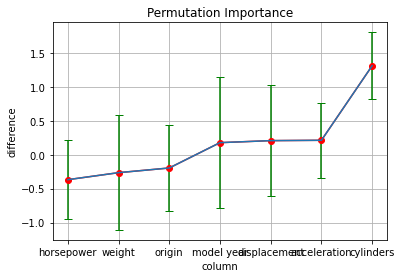

In [39]:
# グラフにプロットする
plt.plot(cols, diff_means, marker='o', color='r')
plt.errorbar(cols, diff_means, yerr=diff_stds_95, ecolor='g', capsize=4)

plt.title('Permutation Importance')
plt.grid()
plt.xlabel('column')
plt.ylabel('difference')
plt.show()